In [ ]:
from utils_python import mcmcroutines as mcmc
from utils_python.transitmcmc import genmcmcInput, getParams
import utils_python.transitplot as transitp
import utils_python.transitfit as transitf
import utils_python.transitmodel as transitm
import utils_python.keplerian as kep
import transitPy5 as tpy5
import transitfit5 as tf
import numpy as np
import time
from exotic_ld import StellarLimbDarkening

/home/aroy/venv/lib/python3.13/site-packages/exotic_ld/ld_grids.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
# Get the data file
tic = 149603524
datadir = "/data2/TESS/ffisearch/cvzsearch_yr1/cvz1toiv2/tlc" + str(tic) + "/"
datafile = "tlc" + str(tic) + ".p.dat"

# Read it
phot = tpy5.readphot(datadir + datafile)

phot.ferr = np.full(len(phot.flux), np.std(phot.flux))

# Read stellar info
st_info = np.genfromtxt(datadir + "stellar_mast.dat")

In [3]:
# Create an initial guess for all 18 parameters

epo = 0.70813
bper = 4.41202
depth = 0.0129872
tdur = 0.1367727

sol = transitm.transit_model_class() # Single planet model has up-to 18-model parameters
sol.rho = kep.rhostar(bper, tdur)    # Mean stellar density (g/cm^3)
sol.nl1 = 0.0    # Only used for non-linear limb-darkening
sol.nl2 = 0.0    # Only used for non-linear limb-darkening
sol.dil = 0.0    # dilution
sol.vof = 0.0    # Velocity offset
sol.zpt = np.median(phot.flux-1)       # Photometric zero point
sol.t0  = [epo]             # Center of transit time (days)
sol.per = [bper]            # Orbital Period (days)
sol.bb  = [0.5]                      # Impact parameter
sol.rdr = [np.sqrt(depth)]  # Rp/R*
sol.ecw = [0.0]  # sqrt(e)cos(w)
sol.esw = [0.0]  # sqrt(e)sin(w)
sol.krv = [0.0]  # RV amplitude (m/s)
sol.ted = [0.0]  # thermal eclipse depth (ppm)
sol.ell = [0.0]  # Ellipsodial variations (ppm)
sol.alb = [0.0]  # Albedo amplitude (ppm)

# Find Kipping limb-darkening coefficients
M_H = st_info[7,1]
Teff = st_info[6,1]
logg = st_info[3,1]

ld_data_path = '/data2/rowe/exotic_ld_data/'
ld_model = 'mps1'
sld = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path)
ld, ld_sig = sld.compute_kipping_ld_coeffs(wavelength_range=[0.6*10000, 1.0*10000], mode="TESS", mu_min=0.1, return_sigmas=True)
sol.nl3 = ld[0]
sol.nl4 = ld[1]

In [8]:
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

logprob_func, sol_to_fit, beta = genmcmcInput(sol, params_to_fit)
niter = 50000

time = phot.time - min(phot.time)

chain, accept = mcmc.genchain(sol_to_fit, beta, niter, logprob_func, mcmc.mhgmcmc, time, phot.flux, phot.ferr, phot.itime)

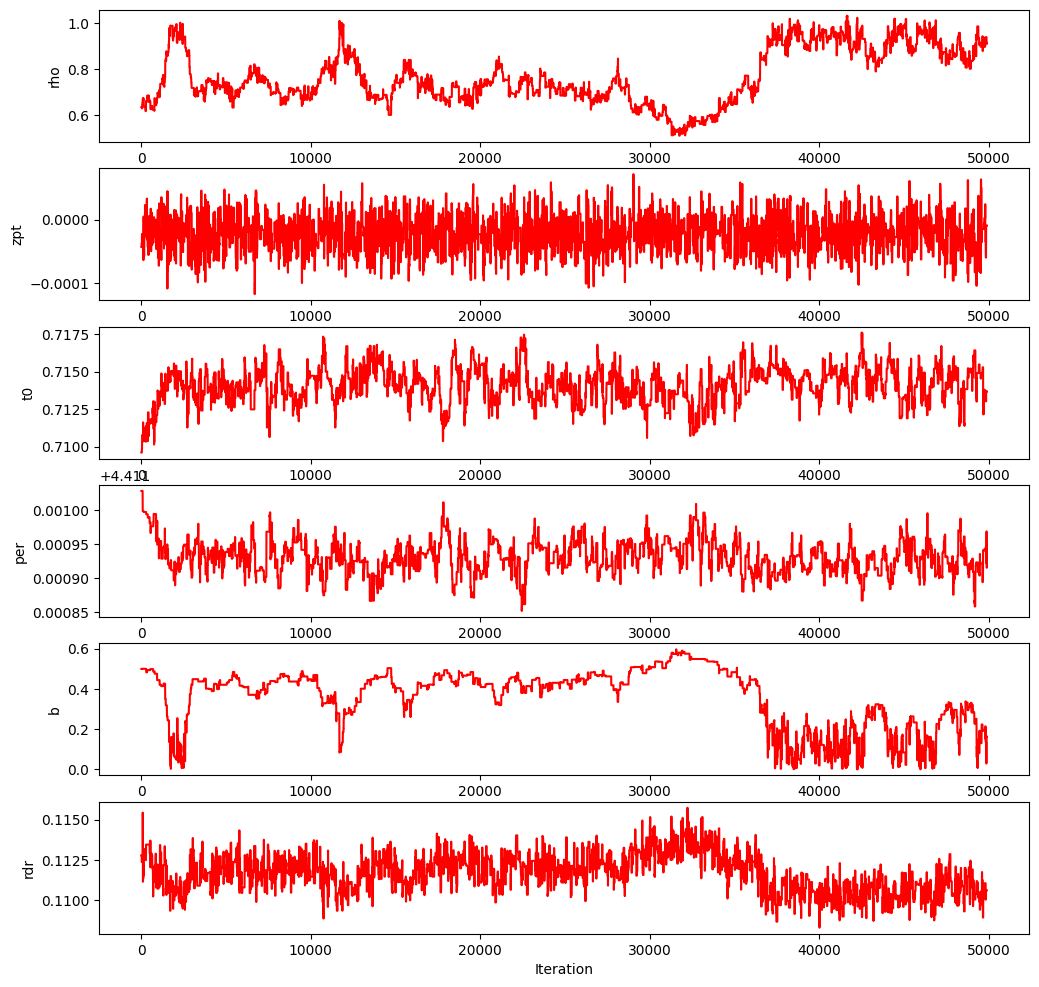

In [9]:
label = ["rho", "zpt", "t0", "per", "b", "rdr"]
color = ["red"]*6
burnin = 100

mcmc.plotchains(chain, label, color, burnin)

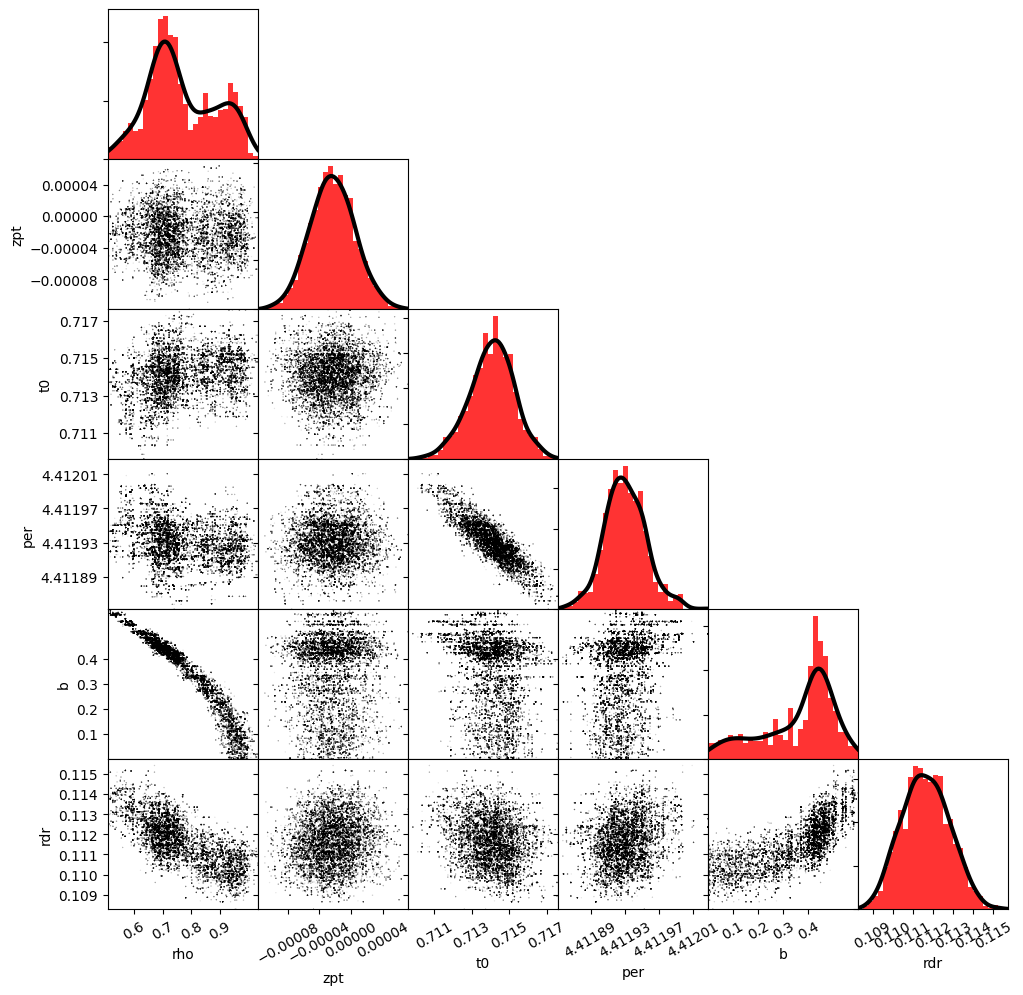

In [10]:
mcmc.triplot(chain, burnin, label, color, 30)

ρ* (g/cm³):                     0.7659059 ± 0.1179483
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.2755473 ± 0.0000000
q2:                             0.2274864 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         0.9999766 ± 0.0000279
t0 (days):                      0.7140684 ± 0.0011868
Period (days):                  4.4119308 ± 0.0000243
Impact parameter:               0.3593429 ± 0.1441363
Rp/R*:                          0.1116448 ± 0.0011666
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0


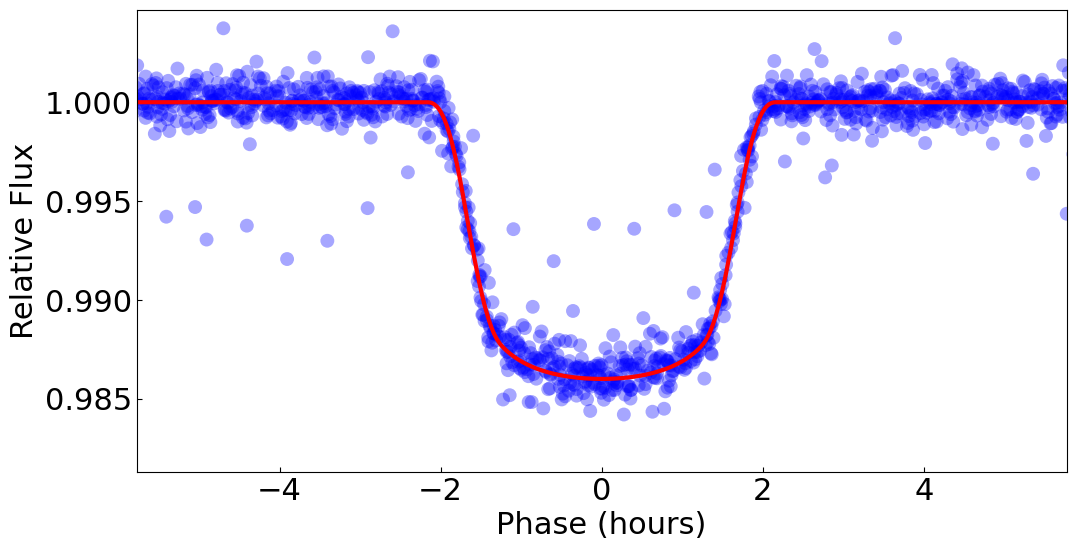

In [15]:
sol_mcmc = getParams(chain, burnin, sol, params_to_fit)
sol_mcmc.zpt += 1 # Temporary offset cause something is off
transitp.printParams(sol_mcmc)
#transitp.plotTransit(phot, sol_mcmc)

In [16]:
mcmc.calcacrate(accept, burnin)

Global Acceptance Rate: 0.208
0 Acceptance Rate 0.193
1 Acceptance Rate 0.309
2 Acceptance Rate 0.224
3 Acceptance Rate 0.165
4 Acceptance Rate 0.113
5 Acceptance Rate 0.242


In [69]:
scale = mcmc.betarescale(sol_to_fit, beta, niter, burnin, logprob_func,
                         mcmc.mhgmcmc, time, phot.flux, phot.ferr, phot.itime)

Too many iterations: icount > imax
Final Acceptance:  [0.25625    0.25308642 0.25316456 0.17730496 0.22289157 0.26515152]


In [17]:
chain1 = chain[:niter//3]
chain2 = chain[niter//3:2*niter//3]
chain3 = chain[2*niter//3:]
mcmc.gelmanrubin(chain1, chain2, chain3, burnin=burnin, npt=len(time))

array([1.57175246, 1.00047715, 1.0399868 , 1.03857004, 1.60893441,
       1.33236366])

## deMCMC test

In [4]:
nsteps1 = 5000#10000 #total length of chain will be nwalkers*nsteps
nsteps2 = 20000#200000 #nstep1 is to check that MCMC is okay, nstep2 is the real work.
nsteps_inc = 10000#100000
burninf=0.5 #burn-in for evalulating convergence
niter_cor=5000
burnin_cor=1000
nthin=101
nloopmax=5
converge_crit=1.02 #Convergence criteria
buf_converge_crit=1.2 #Convergence criteria for buffer
itermax=5 #maximum iterations allowed.
params_to_fit = ["rho", "zpt", "t0", "per", "bb", "rdr"]

In [5]:
# Run a least-squares fit once to get an estimate on errors
phot0 = tpy5.readphot(datadir + datafile)
phot0.ferr = np.full(len(phot0.flux), np.std(phot0.flux))
phot0.time -= min(phot0.time)

sol_fit = transitf.fitTransitModel(sol, params_to_fit, phot0)
serr = sol_fit.err_to_array()
sol_a = sol_fit.to_array()

In [6]:
per = bper

lnprob, x, beta = genmcmcInput(sol_fit, params_to_fit)

In [7]:
start_time = time.time()

phase=(phot0.time-epo)/per-np.floor((phot0.time-epo)/per)
phase[phase<-0.5]+=1.0
phase[phase>0.5]-=1.0

tdurcut=2 #cut out-of-transit data to run faster.
tdur = kep.transitDuration(sol)/per
    
phot=tf.phot_class()
if tdurcut>0:
    phot.time=phot0.time[(phase>-tdurcut*tdur)&(phase<tdurcut*tdur)]
    phot.flux=phot0.flux[(phase>-tdurcut*tdur)&(phase<tdurcut*tdur)]
    phot.ferr=phot0.ferr[(phase>-tdurcut*tdur)&(phase<tdurcut*tdur)]
    phot.itime=phot0.itime[(phase>-tdurcut*tdur)&(phase<tdurcut*tdur)]
else:
    phot.time=np.copy(phot0.time)
    phot.flux=np.copy(phot0.flux)
    phot.ferr=np.copy(phot0.ferr)
    phot.itime=np.copy(phot0.itime)

#Check for run-away model
TPnsteps=5000
TPnthin=1
chain,accept=mcmc.genchain(x,beta,TPnsteps,lnprob,mcmc.mhgmcmc,phot.time,phot.flux,phot.ferr,phot.itime)
runtest=np.array(tf.checkperT0(chain,burninf,TPnthin,sol_a,serr))
print('runtest:',runtest)
runtest2 = runtest + 1.0e-10 #add small eps to avoid division by zero.
if int(np.sum(runtest2[runtest2<1.0]/runtest2[runtest2<1.0]))==4.0:
    TPflag=1 #flag for looping until convergence is met.
else:
    TPflag=0 #run-away
    
#if models are so far so good.. continue
if TPflag==1:

    #get better beta 
    corscale=mcmc.betarescale(x,beta,niter_cor,burnin_cor,lnprob,mcmc.mhgmcmc,phot.time,phot.flux,phot.ferr,phot.itime,imax=10)
    
    #first run with M-H to create buffer.

    nloop=0
    nsteps=np.copy(nsteps1)
    mcmcloop=True
    while mcmcloop==True:
    
        nloop+=1 #count number of loops
        
        hchain1,haccept1=mcmc.genchain(x,beta*corscale,TPnsteps,lnprob,mcmc.mhgmcmc,phot.time,phot.flux,phot.ferr,phot.itime)
        hchain2,haccept2=mcmc.genchain(x,beta*corscale,TPnsteps,lnprob,mcmc.mhgmcmc,phot.time,phot.flux,phot.ferr,phot.itime)
        hchain3,haccept3=mcmc.genchain(x,beta*corscale,TPnsteps,lnprob,mcmc.mhgmcmc,phot.time,phot.flux,phot.ferr,phot.itime)

        if nloop==1:
            chain1=np.copy(hchain1)
            chain2=np.copy(hchain2)
            chain3=np.copy(hchain3)
            accept1=np.copy(haccept1)
            accept2=np.copy(haccept2)
            accept3=np.copy(haccept3)
        else:
            chain1=np.concatenate((chain1,hchain1))
            chain2=np.concatenate((chain2,hchain2))
            chain3=np.concatenate((chain3,hchain3))
            accept1=np.concatenate((accept1,haccept1))
            accept2=np.concatenate((accept2,haccept2))
            accept3=np.concatenate((accept3,haccept3))
        
        burnin=int(chain1.shape[0]*burninf)
        mcmc.calcacrate(accept1,burnin)

        grtest=mcmc.gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
        print('Gelman-Rubin Convergence:')
        print('parameter  Rc')
        for i in range(0,len(chain1[1,:])):
            print('%8s  %.4f' %(str(i),grtest[i]))
        if int(np.sum(grtest[grtest<buf_converge_crit]/grtest[grtest<buf_converge_crit]))==len(grtest):
            mcmcloop=False
        else:
            mcmcloop=True
            nsteps+=nsteps1
            
        runtest=np.array(tf.checkperT0(chain1,burninf,TPnthin,sol_a,serr))
        print('runtest:',runtest)
        if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
            mcmcloop=False #run-away
            
        if nloop>=nloopmax: #break if too many loops
            mcmcloop=False
            
        print("---- %s seconds ----" % (time.time() - start_time))
            
    ## Re-use runtest for buffer creation loop.
    #runtest=np.array(tf.checkperT0(chain1,burninf,TPnthin,sol,serr))
    #print('runtest:',runtest)
    if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))==4.0:
        mcmcloop=True #flag for looping until convergence is met.
    else:
        mcmcloop=False #run-away

    #mcmcloop=True
    nloop=0
    nsteps=np.copy(nsteps2)
    while mcmcloop==True:

        nloop+=1 #count number of loops

        burnin=int(chain1.shape[0]*burninf)
        buffer=np.concatenate((chain1[burnin:],chain2[burnin:],chain3[burnin:])) #create buffer for deMCMC
        x1=np.copy(chain1[chain1.shape[0]-1,:])
        x2=np.copy(chain1[chain1.shape[0]-1,:])
        x3=np.copy(chain1[chain1.shape[0]-1,:])
        corbeta=0.3
        burnin=int(chain1.shape[0]*burninf)
        chain1,accept1=mcmc.genchain(x1,beta*corscale,nsteps,lnprob,mcmc.demhmcmc,phot.time,phot.flux,phot.ferr,phot.itime,buffer=buffer,\
                                corbeta=corbeta)
        chain2,accept2=mcmc.genchain(x2,beta*corscale,nsteps,lnprob,mcmc.demhmcmc,phot.time,phot.flux,phot.ferr,phot.itime,buffer=buffer,\
                                corbeta=corbeta)
        chain3,accept3=mcmc.genchain(x3,beta*corscale,nsteps,lnprob,mcmc.demhmcmc,phot.time,phot.flux,phot.ferr,phot.itime,buffer=buffer,\
                                corbeta=corbeta)

        burnin=int(chain1.shape[0]*burninf)

        grtest=mcmc.gelmanrubin(chain1,chain2,chain3,burnin=burnin,npt=len(phot.time))
        print('Gelman-Rubin Convergence:')
        print('parameter  Rc')
        for i in range(0,len(chain1[1,:])):
            print('%8s  %.4f' %(str(i),grtest[i]))

        if int(np.sum(grtest[grtest<converge_crit]/grtest[grtest<converge_crit]))==len(grtest):
            mcmcloop=False
        else:
            mcmcloop=True

        burnin=int(chain1.shape[0]*burninf)
        chain=np.concatenate((chain1[burnin:,],chain2[burnin:,],chain3[burnin:,]))
        accept=np.concatenate((accept1[burnin:,],accept2[burnin:,],accept3[burnin:,]))
        burnin=int(chain.shape[0]*burninf)
        mcmc.calcacrate(accept,burnin)

        nsteps+=nsteps_inc #make longer chain to help with convergence
        
        #check for run-away Chain.
        runtest=np.array(tf.checkperT0(chain1,burninf,nthin,sol_a,serr))
        print('runtest:',runtest)
        if int(np.sum(runtest[runtest<1.0]/runtest[runtest<1.0]))!=4.0:
            mcmcloop=False #run-away

        if nloop>=nloopmax: #break if too many loops
            mcmcloop=False
            
        print("---- %s seconds ----" % (time.time() - start_time))
        
    print("done %s seconds ---" % (time.time() - start_time))

/home/aroy/bls_cuda/utils_python/mcmcroutines.py:21: RuntimeWarning: overflow encountered in exp
  alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability


runtest: [6.95807302e-04 3.89554088e-04 4.56953156e-06 2.90491649e-05]
Too many iterations: icount > imax
Final Acceptance:  [0.00162866 0.27536232 0.22394366 0.68701095 0.29059829 0.26224784]
Global Acceptance Rate: 0.412
0 Acceptance Rate 0.501
1 Acceptance Rate 0.512
2 Acceptance Rate 0.288
3 Acceptance Rate 0.169
4 Acceptance Rate 0.506
5 Acceptance Rate 0.498
Gelman-Rubin Convergence:
parameter  Rc
       0  1.1254
       1  1.0291
       2  1.0511
       3  1.1404
       4  1.0160
       5  1.0598
runtest: [2.25625140e-04 5.72577005e-04 1.13415647e-05 8.05482553e-06]
---- 168.71770334243774 seconds ----


/home/aroy/bls_cuda/utils_python/mcmcroutines.py:64: RuntimeWarning: overflow encountered in exp
  alpha=min(np.exp(llxt-llx),1.0)          #Step 4 Compute the acceptance probability


Gelman-Rubin Convergence:
parameter  Rc
       0  3.4181
       1  1.0064
       2  1.0167
       3  1.0290
       4  1.7550
       5  1.0268
Global Acceptance Rate: 0.336
0 Acceptance Rate 0.995
1 Acceptance Rate 0.195
2 Acceptance Rate 0.660
3 Acceptance Rate 0.317
4 Acceptance Rate 0.968
5 Acceptance Rate 0.862
deMCMC Acceptance Rate 0.009
runtest: [9.77857356e-04 1.33659792e-03 2.89991798e-05 1.91439898e-05]
---- 282.56264567375183 seconds ----
Gelman-Rubin Convergence:
parameter  Rc
       0  3.8645
       1  1.0019
       2  1.0051
       3  1.0055
       4  2.0607
       5  1.0467
Global Acceptance Rate: 0.671
0 Acceptance Rate 0.999
1 Acceptance Rate 0.210
2 Acceptance Rate 0.639
3 Acceptance Rate 0.342
4 Acceptance Rate 0.988
5 Acceptance Rate 0.867
deMCMC Acceptance Rate 0.669
runtest: [9.77949172e-04 1.27586746e-03 1.92797445e-05 3.00810472e-05]
---- 453.46119022369385 seconds ----
Gelman-Rubin Convergence:
parameter  Rc
       0  1.3844
       1  1.0016
       2  1.0072
   

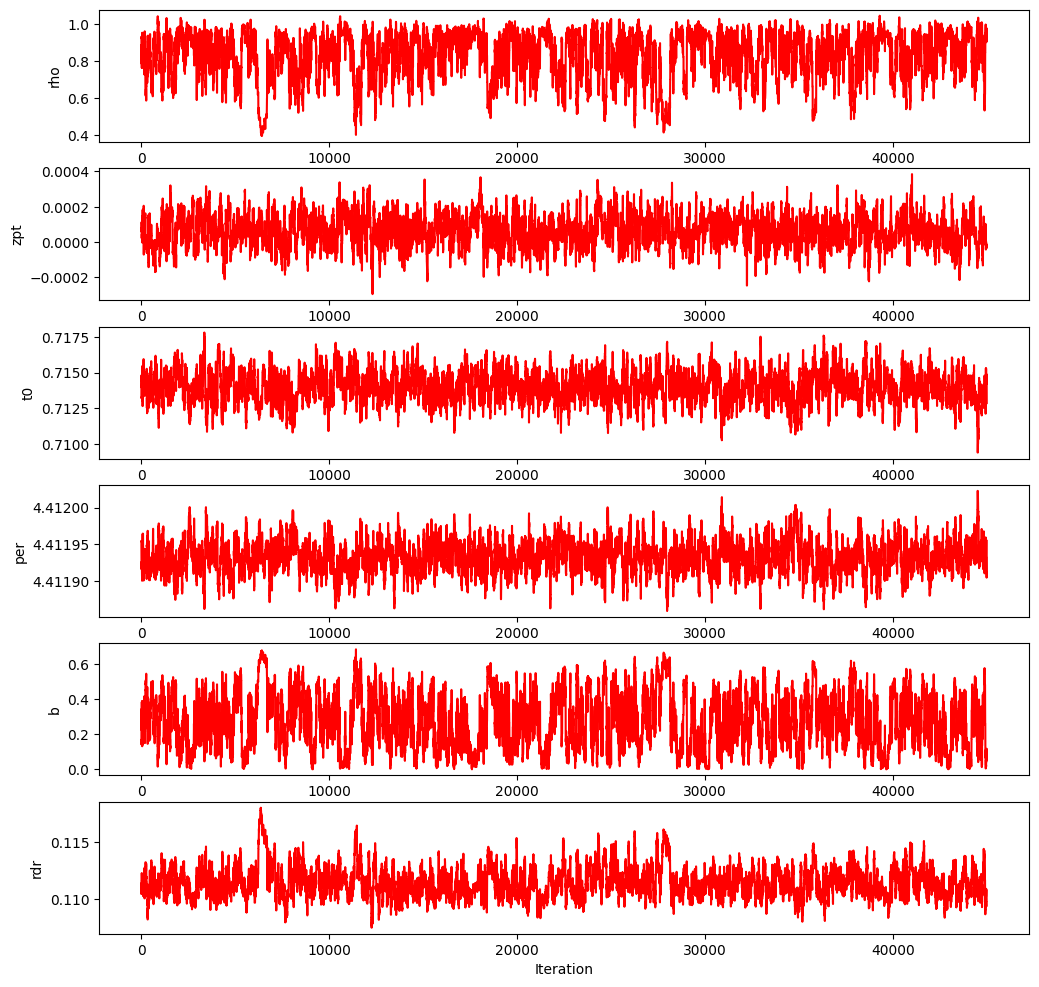

In [8]:
label = ["rho", "zpt", "t0", "per", "b", "rdr"]
color = ["red"]*6

mcmc.plotchains(chain, label, color, burnin)

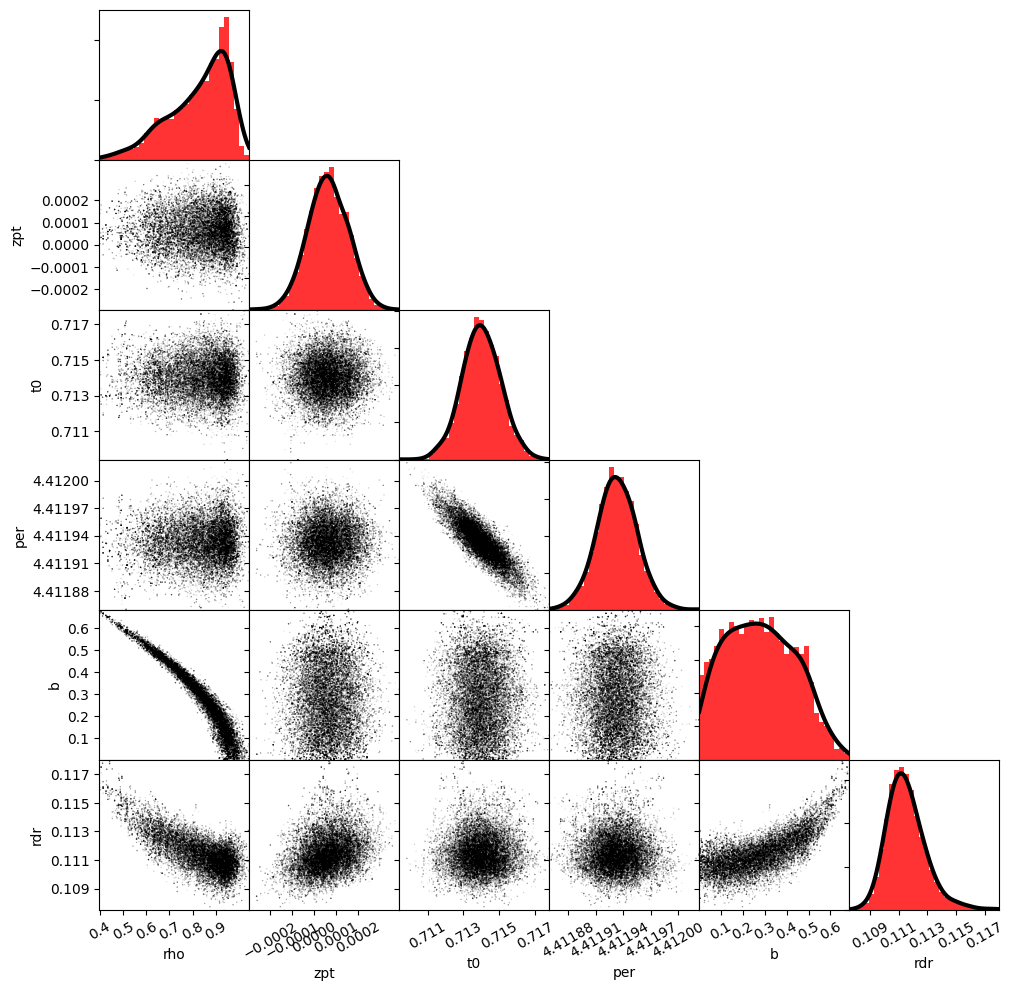

In [9]:
mcmc.triplot(chain, burnin, label, color, 30)

In [11]:
sol_mcmc = getParams(chain, burnin, sol, params_to_fit)
transitp.printParams(sol_mcmc)

ρ* (g/cm³):                     0.8251905 ± 0.1290454
c1:                                   0.0 ± 0.0
c2:                                   0.0 ± 0.0
q1:                             0.2755473 ± 0.0000000
q2:                             0.2274864 ± 0.0000000
Dilution:                             0.0 ± 0.0
Velocity Offset:                      0.0 ± 0.0
Photometric zero point:         6.308e-05 ± 8.916e-05
t0 (days):                      0.7140043 ± 0.0010731
Period (days):                  4.4119330 ± 0.0000216
Impact parameter:               0.2799345 ± 0.1575669
Rp/R*:                          0.1115196 ± 0.0013372
sqrt(e)cos(w):                        0.0 ± 0.0
sqrt(e)sin(w):                        0.0 ± 0.0
RV Amplitude (m/s):                   0.0 ± 0.0
Thermal eclipse depth (ppm):          0.0 ± 0.0
Ellipsoidal variations (ppm):         0.0 ± 0.0
Albedo amplitude (ppm):               0.0 ± 0.0
